# Imports

In [3]:
import pandas as pd
import networkx as nx
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import os
import pickle
from tqdm import tqdm
import analysis_util
import nltk 
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [3]:
# nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt"])

# Data

In [5]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU']
period = '2015-01-01-2022-01-01'

df_post_dict = {}
df_comment_dict = {}
df_all_nodes_dict = {}
G_dict = {}
G_di_dict = {}
df_authors_dict = {}
df_comment_post_dict = {}


for subreddit in subreddits:
    print(subreddit)
    path_post='../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_posts.csv"
    path_comment = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_comments.csv"
    path_awards = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards.csv"
    path_awards_comments = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards_comments.csv"
    
    df_comments=analysis_util.read_comments(path_comment,path_awards_comments)
    df_post=analysis_util.read_posts(path_post,path_awards)
    df_all_nodes=analysis_util.get_all_nodes(df_post,df_comments)    
    G_di = analysis_util.get_DiGraph(df_post,df_comments,df_all_nodes)
    G=analysis_util.get_graph(df_post,df_comments,df_all_nodes)
    G_big=analysis_util.get_biggest_component(G)    
    df_comment_post = analysis_util.get_comment_post_date(df_comments,df_post)
    df_authors = analysis_util.get_authors(G,df_all_nodes,df_comments,df_post,df_comment_post)
    
    df_comment_post_dict[subreddit] = df_comment_post
    df_comment_dict[subreddit] = df_comments
    df_post_dict[subreddit] = df_post
    df_all_nodes_dict[subreddit] = df_all_nodes
    G_dict[subreddit] = G_big
    df_authors_dict[subreddit] = df_authors
    G_di_dict[subreddit] = G_di
    print('')

FourSentenceStories
Removed 0.008264462809917328 of the rows

Trump666
Removed 0.023008849557522026 of the rows

GraphTheory
Removed 0.046391752577319645 of the rows

jazznoir
Removed 0.056192660550458795 of the rows

indoorbouldering
Removed 0.013580246913580174 of the rows

kiwi_bird
Removed 0.01412429378531077 of the rows

DTU
Removed 0.02263374485596703 of the rows



In [6]:
for subreddit in subreddits:
    if 'text' in df_comment_dict[subreddit].columns:
        # rename text column name
        df_comment_dict[subreddit] = df_comment_dict[subreddit].rename(columns={'text':'body'})

# NLTK


<Figure size 1000x500 with 0 Axes>

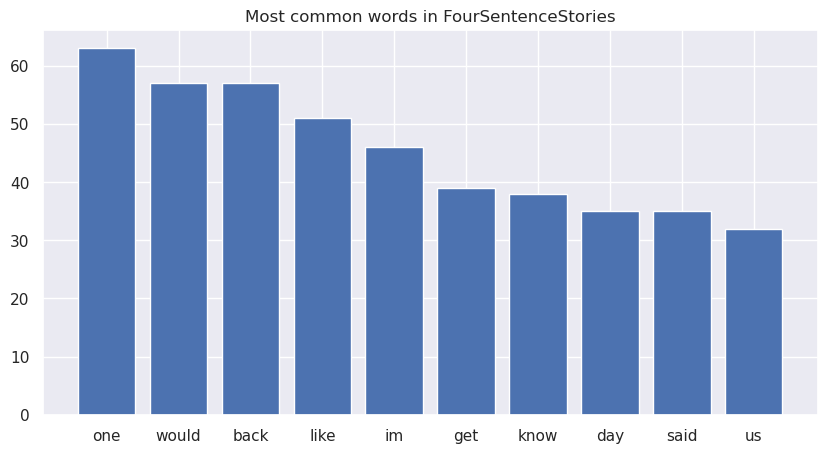

<Figure size 1000x500 with 0 Axes>

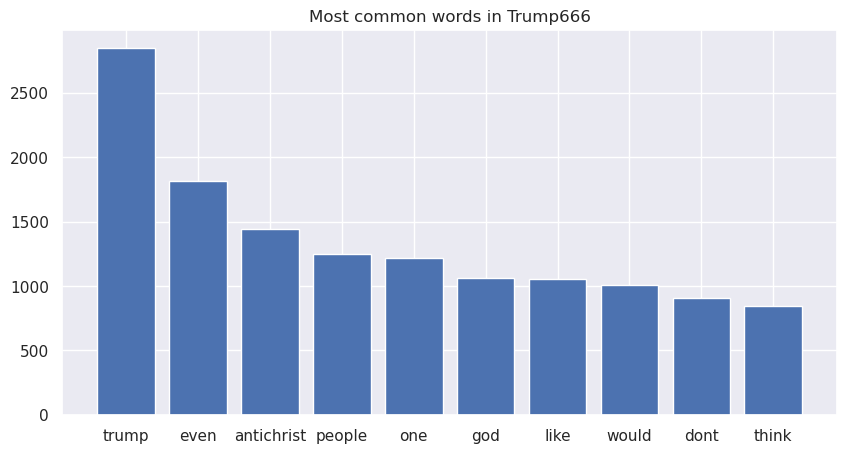

<Figure size 1000x500 with 0 Axes>

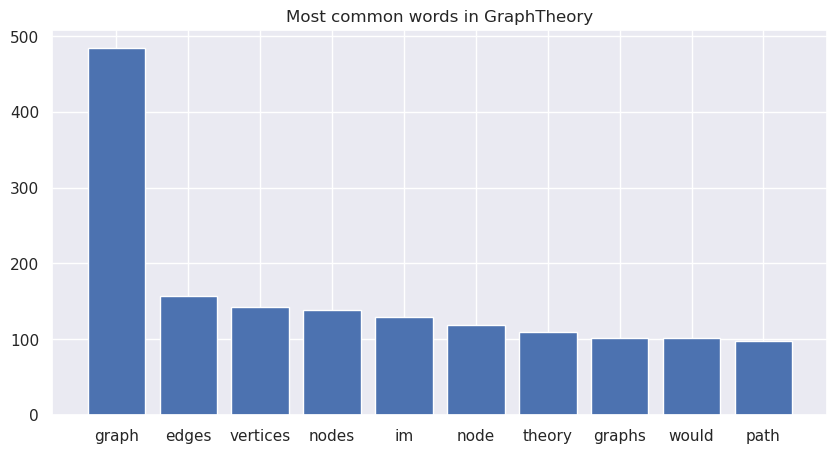

<Figure size 1000x500 with 0 Axes>

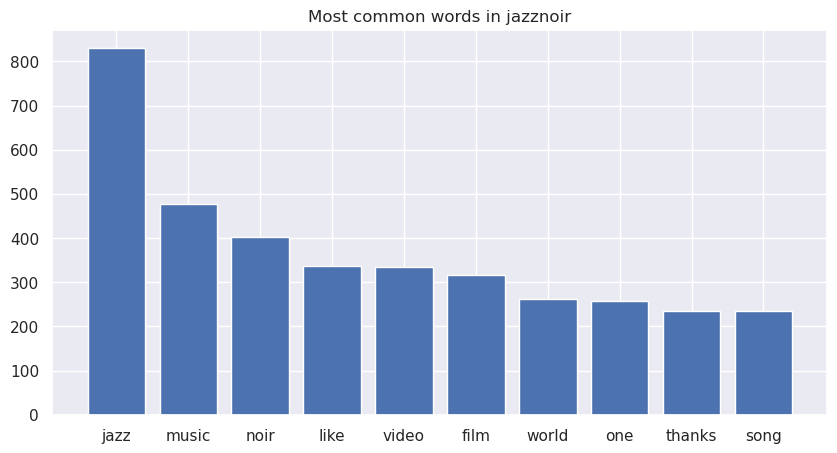

<Figure size 1000x500 with 0 Axes>

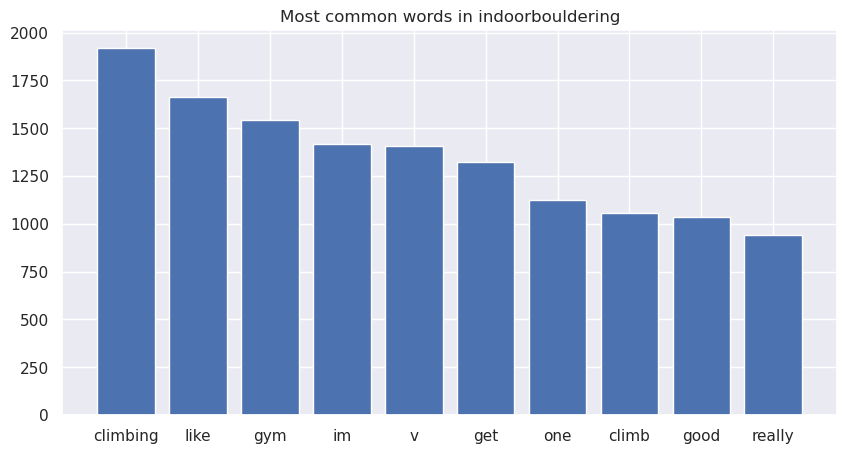

<Figure size 1000x500 with 0 Axes>

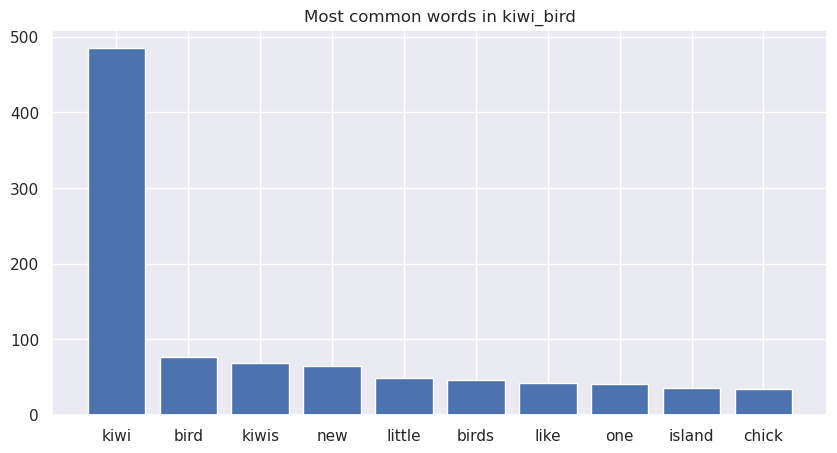

<Figure size 1000x500 with 0 Axes>

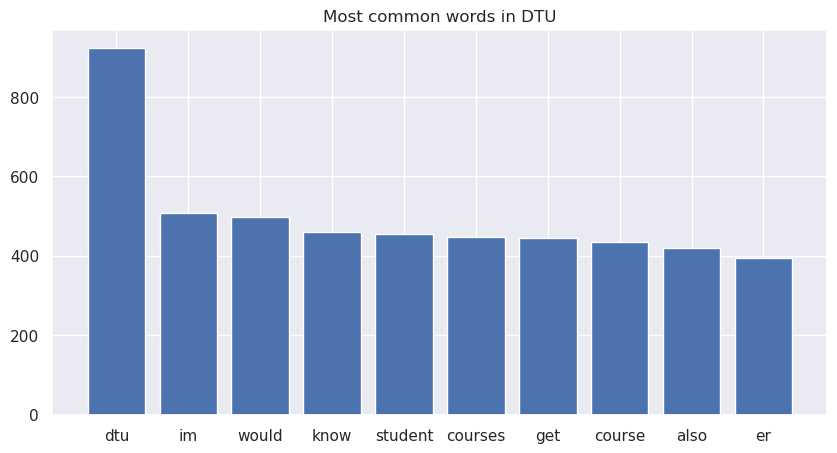

In [7]:
# most said words

stop_words = set(stopwords.words('english'))

def get_most_common_words(df,df_comment, n=10):
    words = []
    df1 = df['text'].apply(lambda x: '' if pd.isna(x) else x) + ' ' + df['title']
    df2 = df_comment['body']
    for text in pd.concat([df1, df2], axis=0):
        if isinstance(text, str):
            text = text.lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            text = text.translate(str.maketrans('', '', string.digits))
            text = text.translate(str.maketrans('', '', '“'))
            text = text.translate(str.maketrans('', '', '”'))
            text = text.translate(str.maketrans('', '', '’'))
            word_tokens = word_tokenize(text)
            words.extend(word_tokens)
        words = [w for w in words if not w in stop_words]
        word_count = Counter(words)
    return word_count.most_common(n)
    
# get_most_common_words(df_post_dict['Trump666'])

# plot most common words
def plot_most_common_words(df,df_comment, n=10, subreddit=subreddit):
    plt.figure(figsize=(10, 5))
    word_count = get_most_common_words(df, df_comment, n)
    words = [w[0] for w in word_count]
    counts = [w[1] for w in word_count]
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.title('Most common words in ' + subreddit)
    plt.show()

for subreddit in subreddits:
    plot_most_common_words(df_post_dict[subreddit], df_comment_dict[subreddit], 10,subreddit)

# Sentiment

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [8]:
def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan


for subreddit in tqdm(subreddits):
    df_post_dict[subreddit]['title_sentiment'] = df_post_dict[subreddit]['title'].apply(lambda x: get_sentiment(x))
    df_post_dict[subreddit]['text_sentiment'] = df_post_dict[subreddit]['text'].apply(lambda x: get_sentiment(x))
    df_comment_dict[subreddit]['sentiment'] = df_comment_dict[subreddit]['body'].apply(lambda x: get_sentiment(x))

100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


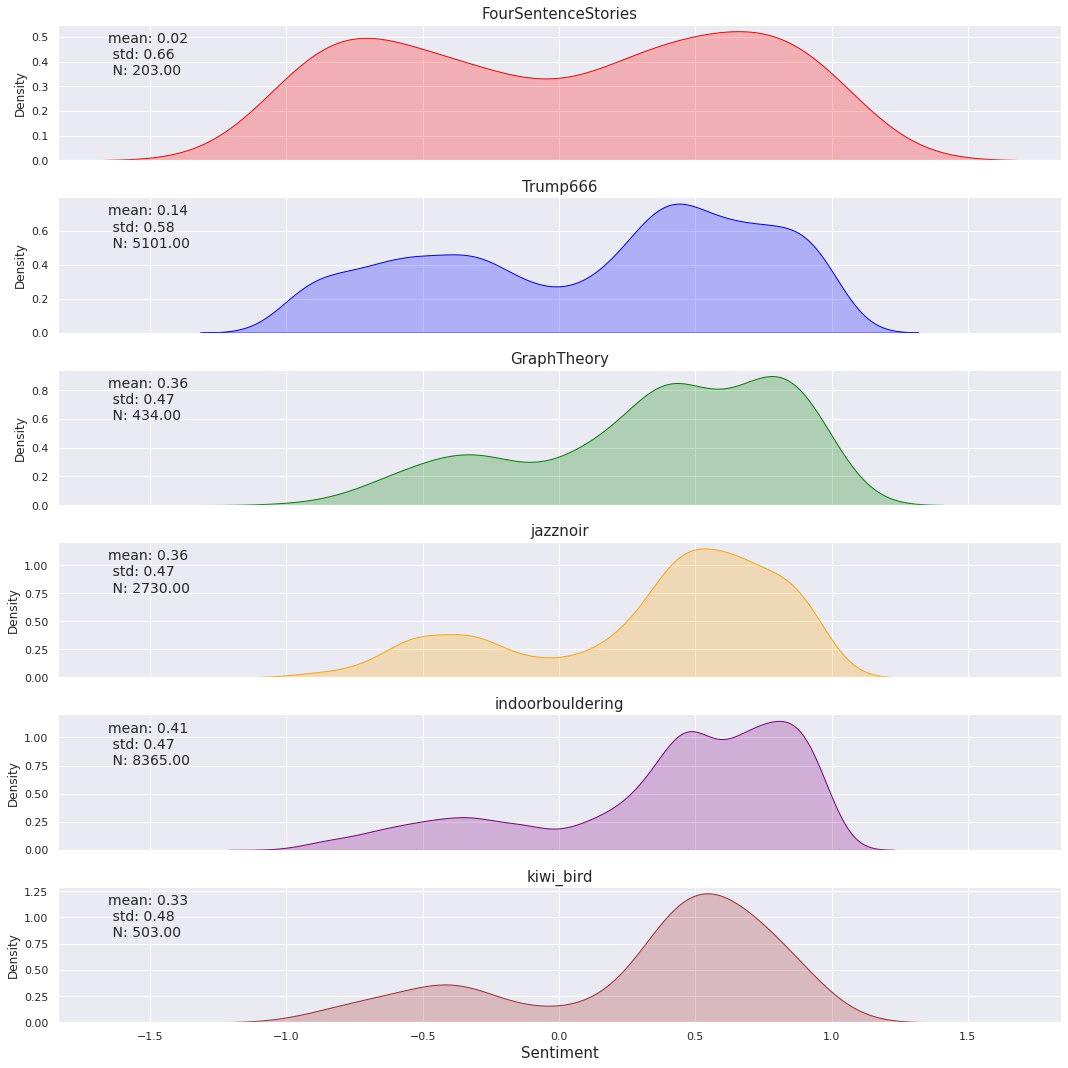

In [9]:
fig, ax = plt.subplots(len(subreddits), 1, figsize=(15, 15), sharex=True)

# color list for each subreddit
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i,sub in enumerate(subreddits):

    sentiments=pd.concat([df_post_dict[sub]['title_sentiment'].dropna(),df_comment_dict[sub]['sentiment'].dropna(),df_post_dict[sub]['text_sentiment'].dropna()])
    # drop zero sentiment
    sentiments=sentiments[sentiments!=0]
    # sns.histplot(sentiments, bins=80,kde=True,alpha=0.4, ax=ax[i],color=colors[i],label=sub)
    sns.kdeplot(list(sentiments), ax=ax[i],color=colors[i],label=sub,shade=True)
    ax[i].set_title(sub,fontsize=15)
    # describe sentiment as text on the plot
    ax[i].text(0.05, 0.95, 'mean: {:.2f} \n std: {:.2f} \n N: {:.2f}'.format(sentiments.mean(), sentiments.std(),sentiments.count()), 
    transform=ax[i].transAxes, fontsize=14, verticalalignment='top')

plt.xlabel('Sentiment',fontsize=15)
plt.tight_layout()
plt.show()